# Classification Metrics: Utilizing Predicted Probabilities

## Thresholding and the Receiver Operator Characteristic Curve

## Objectives

- Calculate and interpret probability estimates
- Adjust the threshold of a logistic regression model
- Visualize, calculate and interpret the AUC-ROC metric

# Motivation

Now that we've learned how to evaluate a classification model's predictions, let's dig deeper to see how else we might evaluate our models and how we can use that information to improve them.

## Scenario: Predicting Polymers

<img src="https://images.pexels.com/photos/248152/pexels-photo-248152.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260" style='width:300px'>

The researchers at SABIC Innovative Plastics US are working on refining the manufacturing process for new polymers. Creating this polymer involves combining 12 materials and 45 mechanical processes (order of processes is unimportant). The prices of ingredients vary as do the amount of time needed for each process done by individual machines that would otherwise be used to make other products. The CSuite requires a pared down list of materials and processes before polymers can go to market. 

A polymer yield greater than or equal to 41 grams is considered "high".

You will use logistic regression to create a classification model find the material and process combination that produces high yield.

### Business Problem

#### End Users:

- Scientists, budgeting department, CSuite

#### True business problem:

- Create a model that can, if given data from from repeated chemical manufacturing trials, predict if the polymer yield will be high (worth the money). 

#### Context: FILL IN THE BLANKS!

- **False negative** in this context: model predicts NOT high yield but it actually is
    - **Outcome**: missed  opportunity
    
- **False positive** in this context: model predicts high yeild but it actually is NOT

    - **Outcome**: wasted money spent on something that isn't worth the investment

#### Evaluation 

Which metric (of the ones we've explore so far) would make sense to primarily use as we evaluate our models?

- Accuracy
- Precision
- Recall
- F1-Score

## Import necessary packages

In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

## Read in data & take a look

In [39]:
df = pd.read_csv('data/ChemicalManufacturingProcess.csv', index_col=0)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 175
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Yield                   176 non-null    float64
 1   BiologicalMaterial01    176 non-null    float64
 2   BiologicalMaterial02    176 non-null    float64
 3   BiologicalMaterial03    176 non-null    float64
 4   BiologicalMaterial04    176 non-null    float64
 5   BiologicalMaterial05    176 non-null    float64
 6   BiologicalMaterial06    176 non-null    float64
 7   BiologicalMaterial07    176 non-null    float64
 8   BiologicalMaterial08    176 non-null    float64
 9   BiologicalMaterial09    176 non-null    float64
 10  BiologicalMaterial10    176 non-null    float64
 11  BiologicalMaterial11    176 non-null    float64
 12  BiologicalMaterial12    176 non-null    float64
 13  ManufacturingProcess01  175 non-null    float64
 14  ManufacturingProcess02  173 non-null    fl

In [41]:
df.head()

,Yield,BiologicalMaterial01,BiologicalMaterial02,BiologicalMaterial03,BiologicalMaterial04,BiologicalMaterial05,BiologicalMaterial06,BiologicalMaterial07,BiologicalMaterial08,BiologicalMaterial09,...,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess41,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
0,38.00,6.25,49.58,56.97,12.74,19.51,43.73,100.0,16.66,11.44,...,0.019,0.5,3.0,7.2,NaN,NaN,11.6,3.0,1.8,2.4
1,42.44,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.019,2.0,2.0,7.2,0.1,0.15,11.1,0.9,1.9,2.2
2,42.03,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,0.7,2.0,7.2,0.0,0.00,12.0,1.0,1.8,2.3
3,41.42,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,1.2,2.0,7.2,0.0,0.00,10.6,1.1,1.8,2.1
4,42.49,7.47,63.33,72.25,14.02,17.91,54.66,100.0,18.22,12.80,...,0.017,0.2,2.0,7.3,0.0,0.00,11.0,1.1,1.7,2.1


## Train test split

Encode `Yield` into `1/0` depending on if it's equal or greater than 41.

In [42]:
# train test split

X = df.drop(columns = ['Yield'])
y = (df['Yield'] >= 41).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Preprocessing
- impute missing values in columns
- scale using max absolute value (this was chosen after trial and error with other scalers)

In [43]:
# Impute missing values with median
imputer = SimpleImputer(strategy='constant', fill_value=0.0)

imputer.fit(X_train)

X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

In [44]:
# Scale using MaxAbsScaler
scaler = MaxAbsScaler()

scaler.fit(X_train_imp)

X_train_pr = scaler.transform(X_train_imp)
X_test_pr = scaler.transform(X_test_imp)

## Create logistic regression model

Using all input features:

In [45]:
logreg = LogisticRegression(random_state = 100)
logreg.fit(X_train_pr, y_train)

LogisticRegression(random_state=100)

In [46]:
# Grab train and test preds
train_preds = logreg.predict(X_train_pr)
test_preds = logreg.predict(X_test_pr)

## Evaluate
Check the accuracy of the model. <br>
Remember, `sklearn` uses a threshold cutoff of `0.5`

In [47]:
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")

Train Accuracy: 0.803030303030303
Test Accuracy: 0.6363636363636364


In [48]:
print(f"Train Accuracy: {f1_score(y_train, train_preds)}")
print(f"Test Accuracy: {f1_score(y_test, test_preds)}")

Train Accuracy: 0.5806451612903226
Test Accuracy: 0.27272727272727276


## But is that the **BEST** cutoff?

If you remember how the logistic regression model works, though, it doesn't actually generate predicted values of 0 or 1. It creates an S-shaped curve to approximate the data, estimating the _probability_ that they belong to the target class. This probability takes a value between 0 and 1. THEN sklearn will round up - anything above .5 becomes a 1, anything below .5 becomes a 0.

<img src="https://www.graphpad.com/guides/prism/latest/curve-fitting/images/hmfile_hash_38a8acae.png" width=600>

Source: [GraphPad](https://www.graphpad.com/guides/prism/latest/curve-fitting/reg_simple_logistic_and_linear_difference.htm)

#### Are We Stuck with the 0.5 Threshold?

But we don't have to do things this way! Suppose we're building a model that predicts the presence of cancer from X-ray scans. And suppose we get a predicted probability of cancer for some particular scan that look like this:

- pred_pos: 0.48

Because false negatives (cancers not flagged) are *much* more costly than false positives (non-cancers flagged as cancers), we may well want to **adjust our threshold**. We might want to have our model predict "positive" if the corresponding probability is, say, 0.4, or maybe even as low as 0.1. (Speaking for myself, if there was even a 10% chance that I had cancer, I'd probably want to know about it.) 

We can get these estimated probabilities using the `.predict_proba()` method. Each element gives two probabilities: the estimate probability of being in the 0 class (not high yield) and the 1 class (high yield)

In [49]:
# get predicted probabilities (log odds) from model for train and test set
# slicing with [:,1] gets the 1st column, probabilities for the 1 class (high yield)
train_probs = logreg.predict_proba(X_train_pr)[:,1]
test_probs = logreg.predict_proba(X_test_pr)[:,1]

### Explore Our Train Set's Predicted Probabilities

In [50]:
train_probs

array([0.1983133 , 0.8074352 , 0.10704101, 0.24313203, 0.07105152,
       0.28833212, 0.20339205, 0.15174109, 0.21543235, 0.12689986,
       0.34411922, 0.25152712, 0.2295839 , 0.6830815 , 0.26860917,
       0.25128548, 0.18249744, 0.14231262, 0.08670719, 0.07649267,
       0.45266748, 0.53027354, 0.23118304, 0.30635294, 0.71372931,
       0.33084181, 0.15737069, 0.27245892, 0.30262286, 0.43135823,
       0.23743569, 0.407896  , 0.31776559, 0.37496896, 0.27414871,
       0.42442719, 0.63183614, 0.14300775, 0.17968496, 0.68051899,
       0.23114884, 0.23854982, 0.73970906, 0.22711906, 0.29032377,
       0.24874968, 0.19683885, 0.66192058, 0.08743367, 0.0833152 ,
       0.08346221, 0.12010677, 0.07685854, 0.49955407, 0.11286034,
       0.23129689, 0.08457215, 0.35264486, 0.21381613, 0.19529681,
       0.25589596, 0.28959803, 0.41979383, 0.32567224, 0.23663304,
       0.11943613, 0.2001809 , 0.25456971, 0.43546886, 0.89816577,
       0.2503956 , 0.76886579, 0.08213452, 0.49752326, 0.52910

In [51]:
y_train_compare = pd.DataFrame(y_train).rename(columns={'Yield':'Actual'})
y_train_compare['Predicted'] = train_preds
y_train_compare['Predicted Probabilities'] = train_probs

In [52]:
y_train_compare.head()

,Actual,Predicted,Predicted Probabilities
142,0,0,0.198313
2,1,1,0.807435
100,0,0,0.107041
122,1,0,0.243132
153,0,0,0.071052


In [53]:
# Check the range of predicted probabilities using .describe
y_train_compare[['Predicted Probabilities']].describe()

,Predicted Probabilities
count,132.000000
mean,0.303028
std,0.192569
min,0.055481
25%,0.161156
50%,0.247541
75%,0.425014
max,0.898166


In [54]:
# Explore where the model gets it wrong, and that range
wrong_preds = y_train_compare.loc[y_train_compare['Actual'] != y_train_compare['Predicted']]
wrong_preds[['Predicted Probabilities']].describe()

,Predicted Probabilities
count,26.000000
mean,0.374115
std,0.140246
min,0.149570
25%,0.248723
50%,0.376008
75%,0.486536
max,0.726672


#### Discuss

- 


Use `for` loop to iterate over various thresholds and calculate metrics for both train and test.

In [55]:
col_names = ['threshold', 'mean_train_pred', 'mean_test_pred', 'train_acc', 'test_acc', 
             'train_prec', 'test_prec', 'train_rec', 'test_rec', 'train_f1', 'test_f1']
metrics_df = pd.DataFrame(columns=col_names)

for x in np.arange(train_probs.min(), train_probs.max(), 0.01):
    threshold = x
    
    y_pred_train = np.where(train_probs > x, 1, 0)
    y_pred_test = np.where(test_probs > x, 1, 0)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    train_prec = precision_score(y_train, y_pred_train)
    test_prec = precision_score(y_test, y_pred_test)
    
    train_rec = recall_score(y_train, y_pred_train)
    test_rec = recall_score(y_test, y_pred_test)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    placeholder = [threshold, y_pred_train.mean(), y_pred_test.mean(),
                   train_acc, test_acc, train_prec, test_prec,
                   train_rec, test_rec, train_f1, test_f1]
    
    sample_S = pd.Series(placeholder, index=col_names)
    metrics_df = metrics_df.append(sample_S, ignore_index=True)

In [56]:
metrics_df.head()

,threshold,mean_train_pred,mean_test_pred,train_acc,test_acc,train_prec,test_prec,train_rec,test_rec,train_f1,test_f1
0,0.055481,0.992424,0.931818,0.310606,0.409091,0.305344,0.365854,1.0,1.0,0.467836,0.535714
1,0.065481,0.984848,0.931818,0.318182,0.409091,0.307692,0.365854,1.0,1.0,0.470588,0.535714
2,0.075481,0.977273,0.931818,0.325758,0.409091,0.310078,0.365854,1.0,1.0,0.473373,0.535714
3,0.085481,0.931818,0.909091,0.371212,0.431818,0.325203,0.375000,1.0,1.0,0.490798,0.545455
4,0.095481,0.909091,0.909091,0.393939,0.431818,0.333333,0.375000,1.0,1.0,0.500000,0.545455


## **Plot** the results

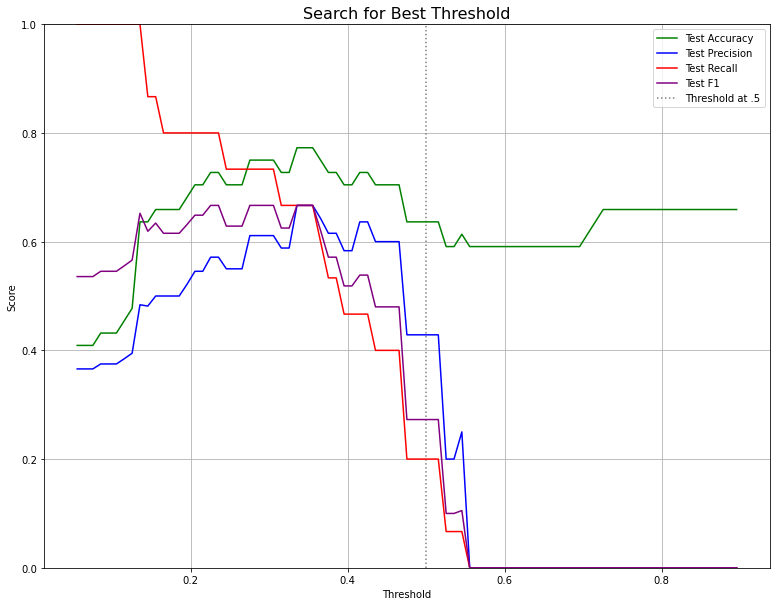

In [57]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Search for Best Threshold", fontsize=16)

ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.grid(True)

ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = metrics_df['threshold'].values

# Currently have all the train metrics hashed out - can unhash to visualize

# ax.plot(X_axis, metrics_df['train_acc'], ls='--', color='g', label='Train Accuracy')
ax.plot(X_axis, metrics_df['test_acc'], color='g', label='Test Accuracy')

# ax.plot(X_axis, metrics_df['train_prec'], ls='--', color='b', label='Train Precision')
ax.plot(X_axis, metrics_df['test_prec'], color='b', label='Test Precision')

# ax.plot(X_axis, metrics_df['train_rec'], ls='--', color='r', label='Train Recall')
ax.plot(X_axis, metrics_df['test_rec'], ls='-', color='r', label='Test Recall')

# ax.plot(X_axis, metrics_df['train_f1'], ls='--', color='purple', label='Train F1')
ax.plot(X_axis, metrics_df['test_f1'], ls='-', color='purple', label='Test F1')

ax.vlines(.5, 0, 1, color='gray', ls='dotted', label='Threshold at .5')

plt.legend()
plt.show()

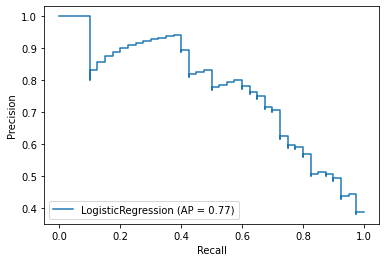

In [58]:
plot_precision_recall_curve(logreg, X_train_pr, y_train)

## Question:

Is `.5` the best cutoff?

- 
  
  
What is the best choice?

- 
  
  
Why?

- 
    

### Adjust The Threshold

If we found a better threshold, we need to implement that manually using the predicted probabilities:

In [59]:
# We can find exactly where to set our threshold using the metrics_df
# Find the max value for the test metric we care about the most
metrics_df.loc[metrics_df['test_f1'] == metrics_df['test_f1'].max()]

,threshold,mean_train_pred,mean_test_pred,train_acc,test_acc,train_prec,test_prec,train_rec,test_rec,train_f1,test_f1
17,0.225481,0.590909,0.477273,0.666667,0.727273,0.474359,0.571429,0.925,0.800000,0.627119,0.666667
18,0.235481,0.545455,0.477273,0.696970,0.727273,0.500000,0.571429,0.900,0.800000,0.642857,0.666667
22,0.275481,0.401515,0.409091,0.765152,0.750000,0.584906,0.611111,0.775,0.733333,0.666667,0.666667
23,0.285481,0.393939,0.409091,0.772727,0.750000,0.596154,0.611111,0.775,0.733333,0.673913,0.666667
24,0.295481,0.356061,0.409091,0.780303,0.750000,0.617021,0.611111,0.725,0.733333,0.666667,0.666667
25,0.305481,0.340909,0.409091,0.795455,0.750000,0.644444,0.611111,0.725,0.733333,0.682353,0.666667
28,0.335481,0.303030,0.340909,0.818182,0.772727,0.700000,0.666667,0.700,0.666667,0.700000,0.666667
29,0.345481,0.287879,0.340909,0.818182,0.772727,0.710526,0.666667,0.675,0.666667,0.692308,0.666667
30,0.355481,0.280303,0.340909,0.825758,0.772727,0.729730,0.666667,0.675,0.666667,0.701299,0.666667


In [60]:
# Use np.where to create an output of 1s and 0s
adj_train_preds = np.where(train_probs > .33, 1, 0)
adj_test_preds = np.where(test_probs > .33, 1, 0)

In [61]:
# Now evaluate:
print(f"Old Train F1: {f1_score(y_train, train_preds)}")
print(f"Old Test F1: {f1_score(y_test, test_preds)}")
print("*"*20)
print(f"New Train F1: {f1_score(y_train, adj_train_preds)}")
print(f"New Test F1: {f1_score(y_test, adj_test_preds)}")

Old Train F1: 0.5806451612903226
Old Test F1: 0.27272727272727276
********************
New Train F1: 0.7160493827160495
New Test F1: 0.6451612903225806


-----

# Further Exploring Probabilities

### True Positive Rate

True Positive Rate (TPR) is the same as *recall*, measuring how many of the positive cases we correctly classified as positive.

> **True Positive Rate (TPR)** = **Recall** = $\frac{TP}{TP + FN}$

AKA: How many of the polymers with high yields did my model identify?


### False Positive Rate

False Positive Rate (FPR) measures how many of the negative cases we incorrectly classified as positive.

> **False Positive Rate (TPR)** = $\frac{FP}{FP + TN}$

AKA: How many of the polymers without high yields did my model flag as high yield?

# The Receiver Operating Characteristic (ROC) Curve

The Receiver Operating Characteristic (ROC) curve plots the true-positive rate vs. the false-positive rate. Let's define these now:

In [62]:
def classify_rates(y_test, y_probs, thresh):
    y_pred = []
    for val in y_probs:            # The val in y_probs shows the probability of 1
        if val > thresh:                # We'll set our own threshold for classifying
            y_pred.append(1)            # a test point as positive! The lower my threshold,
        else:                           # the more predicted positives I'll have
            y_pred.append(0)  
    # Use a confusion matrix to get our tp/tn/fp/fn
    cm = confusion_matrix(y_test, y_pred)
    tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
    # Calculate our true positive rate and false positive rate
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr, f'tpr:{round(tpr, 3)}, fpr:{round(fpr, 3)}'

True- and false-positive rates for various thresholds:

In [63]:
for x in np.linspace(0, 1, 11):
    print(f'Rates at threshold = {x:.2f}: {classify_rates(y_test, test_probs, x)[2]}')

Rates at threshold = 0.00: tpr:1.0, fpr:1.0
Rates at threshold = 0.10: tpr:1.0, fpr:0.862
Rates at threshold = 0.20: tpr:0.8, fpr:0.379
Rates at threshold = 0.30: tpr:0.733, fpr:0.241
Rates at threshold = 0.40: tpr:0.467, fpr:0.172
Rates at threshold = 0.50: tpr:0.2, fpr:0.138
Rates at threshold = 0.60: tpr:0.0, fpr:0.103
Rates at threshold = 0.70: tpr:0.0, fpr:0.069
Rates at threshold = 0.80: tpr:0.0, fpr:0.0
Rates at threshold = 0.90: tpr:0.0, fpr:0.0
Rates at threshold = 1.00: tpr:0.0, fpr:0.0


As my threshold goes up, I'll have fewer positive predictions, which means I'll have both fewer true positives and fewer false positives.

## Plotting the Curve

Let's plot our own ROC curve. We'll create an array of different thresholds and use our `classify_rates()` function to get the true- and false-positive rates for each threshold.

One way of choosing a threshold **independently of business concerns** is to select the point on the curve that is furthest from (1, 0), the "worse-case" point where our true-positive rate is 0 and our false-positive rate is 1. So let's find that point as well:

With a threshold of 0.33: 
	You'll have a True Positive Rate of 0.667 
	and a False Positive Rate of 0.172


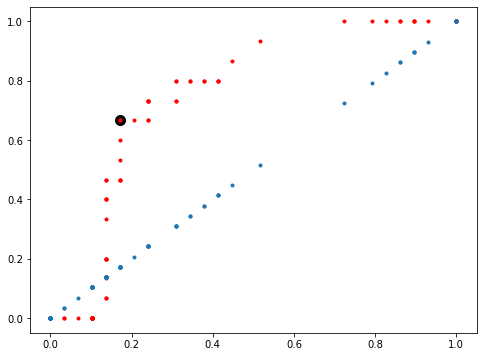

In [64]:
tprs = []
fprs = []
diffs = []
for x in np.linspace(0, 1, 101):
    fprs.append(classify_rates(y_test, test_probs, x)[1])
    tprs.append(classify_rates(y_test, test_probs, x)[0])
    diffs.append(np.sqrt(tprs[-1]**2 + (1-fprs[-1])**2))
    
max_dist = diffs.index(np.max(diffs))
print(f"With a threshold of {(max_dist - 1) / 100}: \n"
      f"\tYou\'ll have a True Positive Rate of {tprs[max_dist]:.3f} \n"
      f"\tand a False Positive Rate of {fprs[max_dist]:.3f}")

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fprs[:max_dist], tprs[:max_dist], 'r.')
ax.plot(fprs[max_dist], tprs[max_dist], 'ko', ms=10)
ax.plot(fprs[max_dist + 1:], tprs[max_dist + 1:], 'r.')
ax.plot(fprs, fprs, '.');

### `plot_roc_curve()`

You can also use sklearn's `plot_roc_curve()` function with your fitted model and test data.

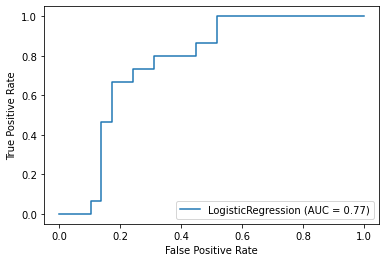

In [65]:
plot_roc_curve(logreg, X_test_pr, y_test);

## Area Under the Curve (AUC)

The ROC curve will be a plot of tpr (on the y-axis) vs. fpr (on the x-axis). There will always be a point at (0, 0) and another at (1, 1). The question is what happens in the middle. Since we want our y-values to be as high as possible for any particular x-value, a natural metric we can evaluate would be to calculate the **area under the curve**. 

> #### The larger the area, the better the classifier. 

The maximum possible area is the area of the whole box between 0 and 1 on both axes, so that's a **maximum area of 1**.

If we have equal numbers of positives and negatives, then we can set an **absolute minimum area of 0.5**. That's the "curve" we'd get by plotting a straight diagonal line from (0, 0) to (1, 1).

Why? The area under the curve really represents the test's ability to **discriminate** positives from negatives. Suppose I randomly took several pairs of points, one positive and one negative, and checked my test's predictions. The area under the receiver operator characteristic curve represents a **threshold-independent measure** of how often my test would get the two predictions correct.

### Some Resources that Explain ROC-AUC Best:

From Analytics Vidhya:

> "The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve."

| Perfect ROC Curve | More Typical ROC Curve | Bad ROC Curve (no better than guessing) |
|---|---|---|
|![perfect ROC curve](images/perfectAUC.webp) | ![more 'normal' ROC curve](images/midAUC.webp) | ![bad ROC curve](images/badAUC.webp) |

---

From [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc):

> "AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is **as the probability that the model ranks a random positive example more highly than a random negative example**. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:
> 
> ![auc predictions ranked](images/AUCPredictionsRanked.svg)
>
> "AUC represents the probability that a random positive (green) example is positioned to the right of a random negative (red) example."


### AUC Calculation with `sklearn`

Scikit-Learn's `roc_auc_score()` function will compute the area under the curve for us:

In [66]:
#THIS NEEDS PROBABILITY
roc_auc_score(y_train, train_probs)

0.86875

In [67]:
roc_auc_score(y_test, test_probs)

0.767816091954023

## Sidebar: Visualizing Threshold Changes

This [ROC Applet](https://web.archive.org/web/20210210014824/http://www.navan.name/roc/) helps  visualize how a change in the threshold corresponds to moving along the ROC curve

# Scenario: Breast Cancer Prediction

Let's evaluate a model using Scikit-Learn's breast cancer dataset:

In [84]:
# Load the data
preds, target = load_breast_cancer(return_X_y=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(preds, target,
                                                    random_state=42)

# Scale the data
bc_scaler = StandardScaler()
bc_scaler.fit(X_train)
X_train_sc = bc_scaler.transform(X_train)
X_test_sc = bc_scaler.transform(X_test)

# Run the model
bc_model = LogisticRegression(solver='lbfgs', max_iter=10000, 
                              random_state=42)
bc_model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=10000, random_state=42)

## Task

For this example, draw the ROC curve and calculate the AUC-ROC metric. Based on the results, do you think your model would be useful for identifying patients with breast cancer?

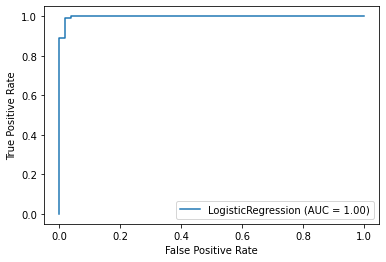

In [85]:
# Your work here
plot_roc_curve(bc_model, X_test_sc, y_test);


In [86]:
roc_auc_score(y_test, bc_model.predict_proba(X_test_sc)[:,1])

0.9977111943404079

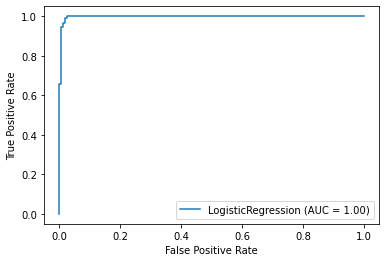

In [87]:
plot_roc_curve(bc_model, X_train_sc, y_train);

In [88]:
roc_auc_score(y_train, bc_model.predict_proba(X_train_sc)[:,1])

0.9972369166824107

-----

# Level Up: Loss Functions

Another more "natural" way of measuring the quality of a classifier is just to look at the loss function, which will often be the **log loss**. 

(In multiclass problems, we use **cross-entropy loss**.)

In [89]:
log_loss(y_test, logreg.predict_proba(X_test_pr))

ValueError: Found input variables with inconsistent numbers of samples: [44, 143]

While such loss values are difficult to interpret on their own, they are useful for comparing models. Models with lower loss values generate probability estimates that are closer to the true values, and thus are likely to perform better on many metrics.

## Log Loss by Hand

Log loss is generally calculated as an average per data point, and is computed as follows:

$L(y, \hat{y}) = -\frac{1}{N}\sum^N_{i=1}[y_i\ln(\hat{y_i}) + (1-y_i)\ln(1-\hat{y_i})]$,

where $y$ is the vector of true values and $\hat{y}$ is the vector of probabilities that the point in question has a correct label of 1.

- Suppose, for a given data point, that the correct prediction of the label is **0**. In that case, the contribution from that point to the sum in the loss function defined above will be $-\ln(1-\hat{y_i})$. So, the closer the prediction for that point is to 0, the closer the contribution to the sum will be to $-\ln(1)=0$. But as the prediction gets closer to 1, the closer the contribution will be to $-\ln(0)=\infty$.

- Suppose, on the other hand, that the correct prediction is **1**. In that case, the contribution from that point to the sum in the loss function defined above will be $-\ln(\hat{y_i})$. So, the closer the prediction for that point is to 1, the closer the contribution to the sum will be to $-\ln(1)=0$. But as the prediction gets closer to 0, the closer the contribution will be to $-\ln(0)=\infty$.

In [ ]:
compare = list(zip(y_test, logreg.predict_proba(X_test_pr)))

In [ ]:
compare[:5]

In [ ]:
calc = [-(yi * np.log(yi_hat[1]) + (1 - yi) * np.log(yi_hat[0])) for (yi, yi_hat) in compare]
calc[:5]

In [ ]:
np.mean(calc)